In [43]:
# setup chunk

## for deep learning architecture and evaluation
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## for plotting
from PIL import Image
import matplotlib.pyplot as plt

## for preprocessing
import os
import numpy as np
import random
import math
import pandas as pd

## set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [44]:
# load csv file with box annotations
person_annotations = pd.read_csv('../../02_data/Google_OpenImages/filtered_person_annotations.csv')

# specify image folder
image_folder = '../../02_data/Google_OpenImages/person_images_small/'

# Count the number of bounding boxes per image
image_counts = person_annotations.groupby('ImageID').size().reset_index(name='Count')

# Convert to dictionary for easy lookup
image_counts_dict = dict(zip(image_counts['ImageID'], image_counts['Count']))

In [45]:
image_ids = list(image_counts_dict.keys())
train_keys = image_ids[:50]
val_keys = image_ids[50:100]

train_dict = {k: image_counts_dict[k] for k in train_keys}
val_dict = {k: image_counts_dict[k] for k in val_keys}

In [46]:
class PeopleCountingDataset(Dataset):
    def __init__(self, image_folder, annotations_dict, transform=None):
        self.image_folder = image_folder
        self.annotations_dict = annotations_dict
        self.transform = transform
        self.image_ids = list(self.annotations_dict.keys())
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_folder, image_id + ".jpg")
        image = Image.open(image_path).convert("RGB")
        
        count = self.annotations_dict[image_id]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(count, dtype=torch.float32)

In [47]:
# create transformation objects
train_transform = transforms.Compose([
    transforms.Resize((128, 128)), # rescale to uniform size (rescaling can lead to distortions if input not square)
    transforms.RandomHorizontalFlip(), # randomly flip horizontally
    transforms.RandomRotation(10), # randomly rotate by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # random affine transformations
    transforms.ToTensor(), # transform to tensor, brings pixels to range (0, 1)
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalize to range (-1, 1) for all three channels
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Create training and validation datasets
train_dataset = PeopleCountingDataset(image_folder, train_dict, transform=train_transform)
val_dataset = PeopleCountingDataset(image_folder, val_dict, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [56]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(CustomResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        last_conv_output = self.layer4(x)
        
        x = self.avgpool(last_conv_output)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x, last_conv_output

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = CustomResNet(BasicBlock, [2, 2, 2, 2]).to(device)

# Print model summary for input size (3, 128, 128)
summary(resnet_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [49]:
# define the CNN class

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),  # Slightly increased dropout
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),  # Slightly increased dropout
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)   # Slightly increased dropout
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*16*16, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

# Instantiate the model
cnn_model = CNN().to(device)

summary(cnn_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
         MaxPool2d-4            [-1, 8, 64, 64]               0
           Dropout-5            [-1, 8, 64, 64]               0
            Conv2d-6           [-1, 16, 64, 64]           1,168
       BatchNorm2d-7           [-1, 16, 64, 64]              32
              ReLU-8           [-1, 16, 64, 64]               0
         MaxPool2d-9           [-1, 16, 32, 32]               0
          Dropout-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           4,640
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
        MaxPool2d-14           [-1, 32,

In [50]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [51]:
def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]

            optimizer.zero_grad()
            output, _ = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]
                output, _ = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

Epoch: 1, Training Loss: 21.1604, Validation Loss: 39.5582
Validation loss decreased (39.558192 --> 39.558192).  Saving model ...
Epoch: 2, Training Loss: 18.3175, Validation Loss: 32.9308
Validation loss decreased (39.558192 --> 32.930773).  Saving model ...
Epoch: 3, Training Loss: 20.8311, Validation Loss: 71.5104
Epoch: 4, Training Loss: 23.1506, Validation Loss: 88.9357
Epoch: 5, Training Loss: 20.7877, Validation Loss: 62.8269
Epoch: 6, Training Loss: 18.1769, Validation Loss: 34.2457
Epoch: 7, Training Loss: 14.4106, Validation Loss: 33.3391
Epoch: 8, Training Loss: 20.5135, Validation Loss: 36.2705
Epoch: 9, Training Loss: 14.9331, Validation Loss: 32.8776
Validation loss decreased (32.930773 --> 32.877579).  Saving model ...
Epoch: 10, Training Loss: 14.9018, Validation Loss: 32.3623
Validation loss decreased (32.877579 --> 32.362335).  Saving model ...
Epoch: 11, Training Loss: 18.9211, Validation Loss: 33.4130
Epoch: 12, Training Loss: 22.5689, Validation Loss: 34.3989
Epoch

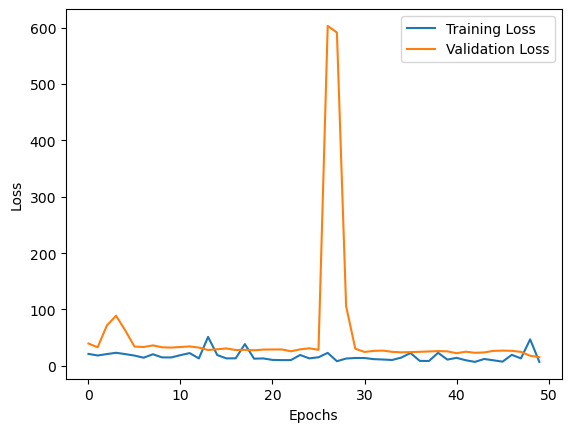

In [60]:
# set hyperparameters
epochs = 50
patience = 20
lr = 0.0005
reg = 0.0001

criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(resnet_model.parameters(), lr=lr, weight_decay=reg)
early_stopper = EarlyStopping(patience=patience)

# training the model
train_losses, val_losses = train_cnn_model(epochs, resnet_model, cnn_optimizer, criterion, train_loader, val_loader, early_stopper)

# plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, count in data_loader:
            images, count = images.to(device), count.to(device)
            outputs, _ = model(images)
            y_preds.extend(outputs.cpu().numpy())
            y_true.extend(count.cpu().numpy())

    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return mae, mse, r2

In [62]:
# evaluate on the validation set
evaluation_metrics = evaluate_model(val_loader, resnet_model)

Mean Absolute Error (MAE): 3.0254
Mean Squared Error (MSE): 16.1525
R-squared (R2): -0.2486


In [ ]:
# evaluate on the test set

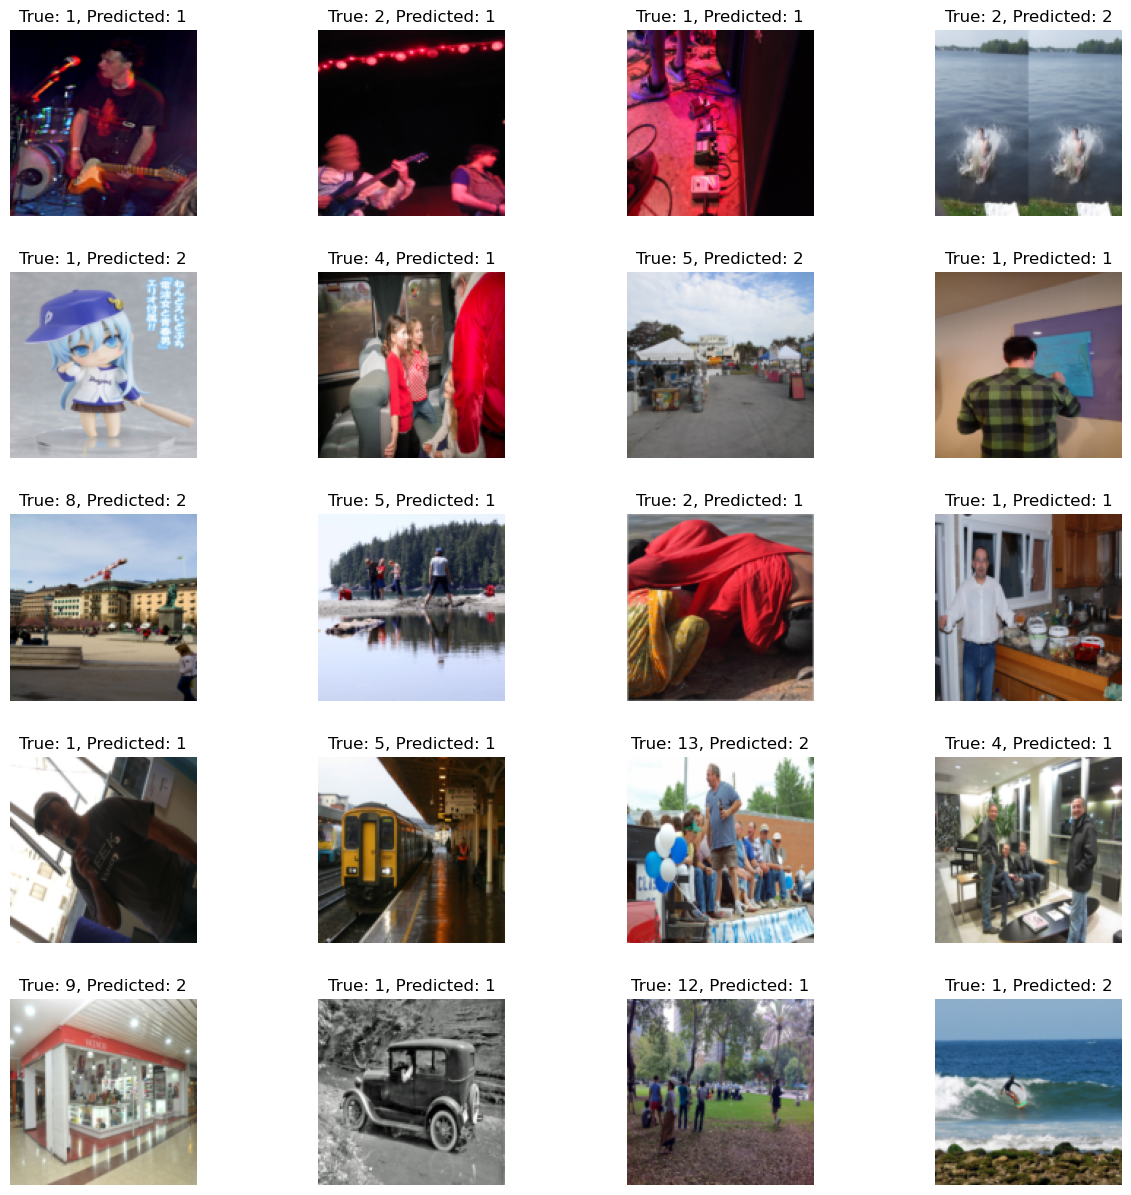

In [66]:
def visualize_prediction(model, dataset, number_of_images):
    model.eval()

    random_indices = random.sample(range(len(dataset)), number_of_images)

    # Calculate grid size
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Adjust figure size based on rows
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, idx in enumerate(random_indices):
        image, true_count = dataset[idx]
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            predicted_count, _ = model(image_tensor)
            predicted_count = torch.round(predicted_count).item()  # Round and convert to scalar
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = image_np * 0.5 + 0.5

            if rows == 1 and cols == 1:
                ax = axes
            elif rows == 1 or cols == 1:
                ax = axes[i]
            else:
                ax = axes[i // cols, i % cols]

            ax.imshow(image_np)
            ax.set_title(f"True: {int(true_count)}, Predicted: {int(predicted_count)}")
            ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(cnn_model, val_dataset, number_of_images=20)